In [9]:
import os

os.getcwd()  # show current working directory


'/Users/jacobbanov/FOMC-statement-S-P-500-time-series-analysis'

In [10]:
import os
import pandas as pd
import numpy as np

# ================ 0. Check where we are & what files exist ================
print("CWD:", os.getcwd())
print("output/ contains:", os.listdir("outputs"))
print("data/ contains:", os.listdir("data"))

# >>> If you see a different predictions filename in output/,
# >>> change the line below to match it exactly.
pred_path = "outputs/monthly_aggregated_predictions.csv"   # EDIT IF NEEDED
sp_path   = "data/sp500_monthly.csv"

# ================ 1. Load data ================
pred = pd.read_csv(pred_path)
sp   = pd.read_csv(sp_path)

print("Pred columns:", pred.columns.tolist())
print("SP500 columns:", sp.columns.tolist())

# ================ 2. Ensure year_month exists in pred ================
if "year_month" not in pred.columns:
    # try likely date columns in your predictions file
    date_col_pred = None
    for cand in ["statement_date", "DATE", "date"]:
        if cand in pred.columns:
            date_col_pred = cand
            break
    if date_col_pred is None:
        raise ValueError(
            "Could not find a date column in predictions "
            "(tried statement_date/DATE/date). "
            f"Available: {pred.columns.tolist()}"
        )
    pred[date_col_pred] = pd.to_datetime(pred[date_col_pred])
    pred["year_month"] = pred[date_col_pred].dt.strftime("%Y-%m")

# ================ 3. Build year_month + returns for SP500 ================
# sp500_monthly has: observation_date, SP500

sp["observation_date"] = pd.to_datetime(sp["observation_date"])
sp["year_month"] = sp["observation_date"].dt.strftime("%Y-%m")

# Sort and compute forward 1-month return from index levels
sp = sp.sort_values("year_month")
sp["sp500_return"] = sp["SP500"].shift(-1) / sp["SP500"] - 1   # forward return
sp = sp.dropna(subset=["sp500_return"])

# ================ 4. Merge predictions with SP500 returns ================
df = pred.merge(sp[["year_month", "sp500_return"]], on="year_month", how="inner")
df["return_decimal"] = df["sp500_return"]

# Identify model score columns (exclude actual_score, which is label sentiment)
model_cols = [c for c in df.columns if c.endswith("_score") and c != "actual_score"]
print("Model columns:", model_cols)

# ================ 5. Allocation rule based on sentiment ================
def allocation_from_sentiment(pct_pos: float) -> float:
    """
    Map fraction of positive paragraphs to portfolio weight in SP500.
    pct_pos = (sum of +/-1 predictions) / n_paragraphs
    """
    if pct_pos <= 0:
        return 0.00   # all negative or zero -> stay in cash
    elif pct_pos <= 0.50:
        return 0.25
    elif pct_pos <= 0.75:
        return 0.50
    elif pct_pos < 1.00:
        return 0.75
    else:
        return 1.00   # 100% positive paragraphs

# ================ 6. Run backtest for each model ================
initial_capital = 100.0
results = {}

for model in model_cols:
    pv = initial_capital
    history = []

    for _, row in df.iterrows():
        score = row[model]
        n_par = row["n_paragraphs"]

        # sentiment score is sum of +/-1 → fraction of paragraphs that are positive
        pct_positive = score / n_par
        weight = allocation_from_sentiment(pct_positive)

        # apply forward 1-month SP500 return with that weight
        pv *= (1 + weight * row["return_decimal"])
        history.append(pv)

    results[model] = history

# ================ 7. Build backtest results table ================
backtest_df = pd.DataFrame(results, index=df["year_month"])
backtest_df.index.name = "Period"

backtest_df


CWD: /Users/jacobbanov/FOMC-statement-S-P-500-time-series-analysis
output/ contains: ['binary_2025_predictions.csv', 'binary_TransformerClassifier_cm.png', 'validation_analysis.csv', '.DS_Store', 'binary_MLP_cm.png', 'binary_ResNetMLP_best.pth', 'fed_sentiment_over_time.png', 'binary_AttentionMLP_best.pth', 'binary_CNN1D_best.pth', 'binary_AttentionMLP_cm.png', 'binary_CNN1D_cm.png', 'fed_sentiment_eda.png', 'binary_TransformerClassifier_best.pth', 'monthly_aggregated_predictions.csv', 'binary_MLP_best.pth', 'binary_AutoencoderClassifier_best.pth', 'binary_ResNetMLP_cm.png']
data/ contains: ['sp500_raw.csv', 'sp500_features.csv', '2025_sp500_monthly.csv', 'sp500_monthly.csv', 'sp500_2025_buckets_and_onehot.csv', 'all_fed_paragraphs_v2.csv', 'fed_sentiment_results.csv', 'merged_paragraph_level.csv', 'merged_sentiment_market.csv']
Pred columns: ['year_month', 'statement_date', 'DATE', 'actual_score', 'n_paragraphs', 'MLP_score', 'CNN1D_score', 'AttentionMLP_score', 'ResNetMLP_score', 'Au

,MLP_score,CNN1D_score,AttentionMLP_score,ResNetMLP_score,AutoencoderClassifier_score,TransformerClassifier_score
Period,,,,,,
2025-01,98.931840,98.931840,99.643947,99.287894,98.931840,98.931840
2025-02,93.238836,93.238836,95.343460,93.574400,93.238836,93.238836
2025-05,97.864116,97.864116,97.708302,97.055845,97.864116,97.864116
2025-06,99.984496,99.984496,98.766804,98.632995,99.984496,99.984496
2025-07,101.414262,101.414262,99.708373,100.043435,101.890851,101.890851


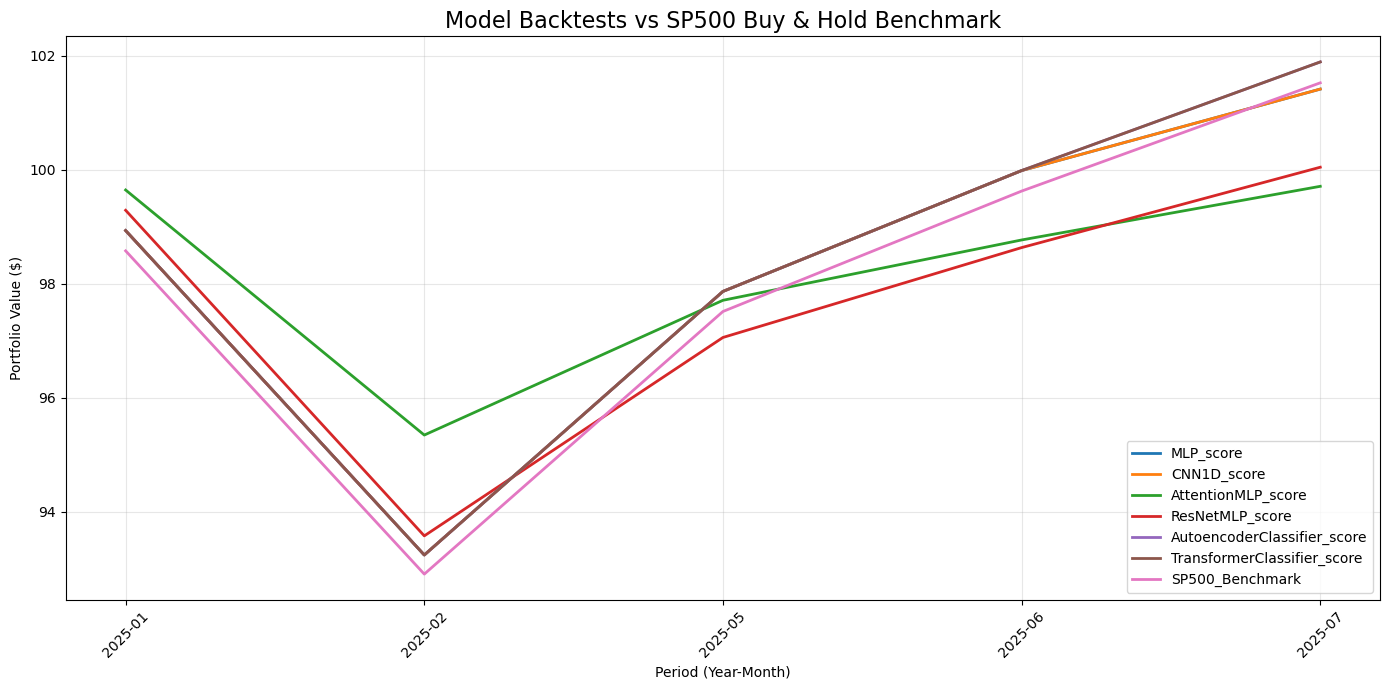

'\nfig, axes = plt.subplots(nrows=len(backtest_df.columns), ncols=1, figsize=(12, 3*len(backtest_df.columns)))\n\nfor ax, col in zip(axes, backtest_df.columns):\n    ax.plot(backtest_df.index, backtest_df["SP500_Benchmark"], label="SP500 Benchmark", linewidth=2)\n    ax.plot(backtest_df.index, backtest_df[col], label=col, linewidth=2)\n    ax.set_title(f"{col} vs Benchmark")\n    ax.grid(True, alpha=0.3)\n    ax.legend()\n    ax.set_xticklabels(backtest_df.index, rotation=45)\n\nplt.tight_layout()\nplt.show()\n'

In [11]:
import matplotlib.pyplot as plt

# ============================
# 1. Build SP500 Buy & Hold Benchmark
# ============================

# Start at $100 just like models
benchmark = [100]
pv = 100

# df return_decimal = forward 1-month SP500 return
for r in df["return_decimal"]:
    pv *= (1 + r)      # 100% weight in SP500
    benchmark.append(pv)

# Drop initial extra benchmark value
benchmark = benchmark[1:]

# Add benchmark to the backtest_df
backtest_df["SP500_Benchmark"] = benchmark

# ============================
# 2. Plot all models + SP500 benchmark
# ============================

plt.figure(figsize=(14,7))

for col in backtest_df.columns:
    plt.plot(backtest_df.index, backtest_df[col], label=col, linewidth=2)

plt.title("Model Backtests vs SP500 Buy & Hold Benchmark", fontsize=16)
plt.xlabel("Period (Year-Month)")
plt.ylabel("Portfolio Value ($)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# ============================
# OPTIONAL: Individual subplots (uncomment if you want)
# ============================
"""
fig, axes = plt.subplots(nrows=len(backtest_df.columns), ncols=1, figsize=(12, 3*len(backtest_df.columns)))

for ax, col in zip(axes, backtest_df.columns):
    ax.plot(backtest_df.index, backtest_df["SP500_Benchmark"], label="SP500 Benchmark", linewidth=2)
    ax.plot(backtest_df.index, backtest_df[col], label=col, linewidth=2)
    ax.set_title(f"{col} vs Benchmark")
    ax.grid(True, alpha=0.3)
    ax.legend()
    ax.set_xticklabels(backtest_df.index, rotation=45)

plt.tight_layout()
plt.show()
"""


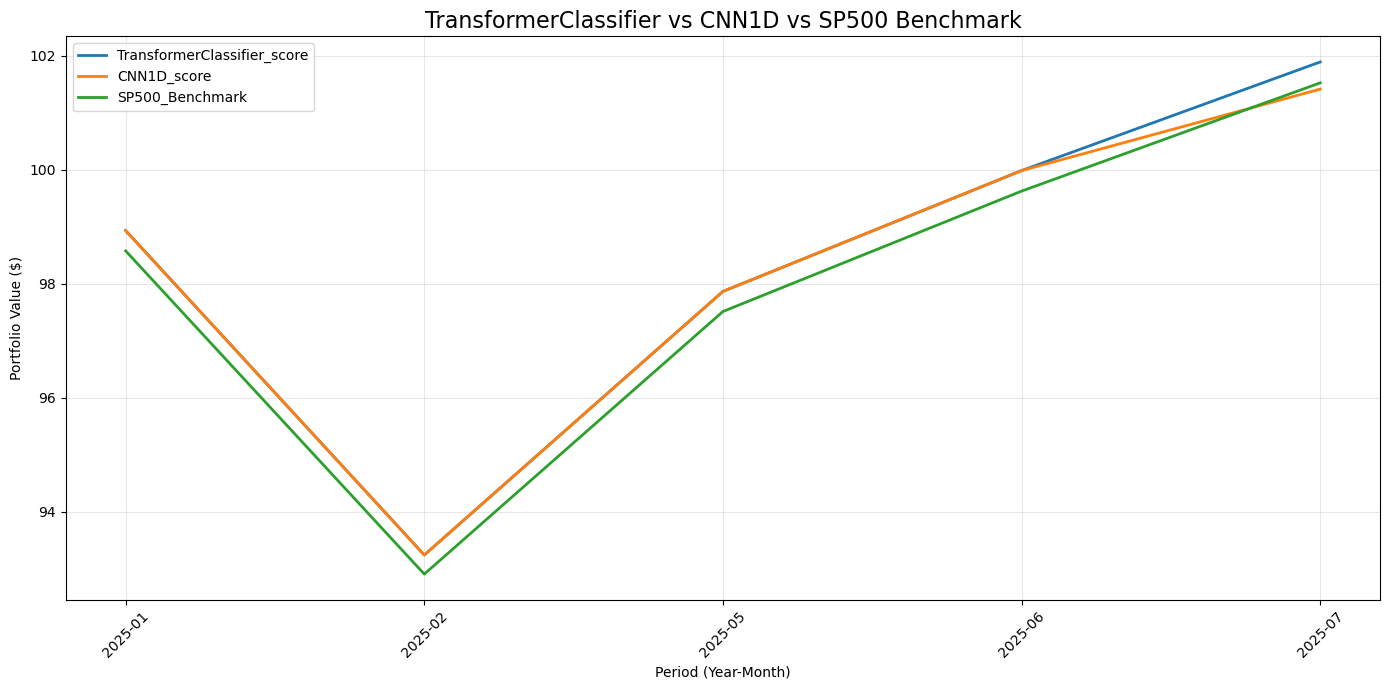

In [12]:
import matplotlib.pyplot as plt

# ============================
# 1. Build SP500 Buy & Hold Benchmark
# ============================

benchmark = [100]
pv = 100

for r in df["return_decimal"]:
    pv *= (1 + r)
    benchmark.append(pv)

benchmark = benchmark[1:]  # drop initial placeholder
backtest_df["SP500_Benchmark"] = benchmark

# ============================
# 2. Plot ONLY: TransformerClassifier, CNN1D, SP500 Benchmark
# ============================

plt.figure(figsize=(14,7))

cols_to_plot = [
    "TransformerClassifier_score",
    "CNN1D_score",
    "SP500_Benchmark"
]

for col in cols_to_plot:
    plt.plot(
        backtest_df.index,
        backtest_df[col],
        label=col,
        linewidth=2
    )

plt.title("TransformerClassifier vs CNN1D vs SP500 Benchmark", fontsize=16)
plt.xlabel("Period (Year-Month)")
plt.ylabel("Portfolio Value ($)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
